# Déploiment projet de ML

### 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

import warnings
warnings.filterwarnings("ignore")

### 2. Import data source and read it

In [324]:
df = pd.read_excel('Risque_data.xlsx')
df.head()

,A1,A2,A3,A4,A5,A6,A7,Risque
0,30.83,0.000,202.0,0,g,w,v,Risque Elevé
1,58.67,4.460,43.0,560,g,q,h,Risque Elevé
2,24.50,0.500,280.0,824,g,q,h,Risque Elevé
3,27.83,1.540,100.0,3,g,w,v,Risque Elevé
4,20.17,5.625,120.0,0,g,w,v,Risque Elevé


In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      678 non-null    float64
 1   A2      690 non-null    float64
 2   A3      677 non-null    float64
 3   A4      690 non-null    int64  
 4   A5      684 non-null    object 
 5   A6      681 non-null    object 
 6   A7      681 non-null    object 
 7   Risque  690 non-null    object 
dtypes: float64(3), int64(1), object(4)
memory usage: 43.3+ KB


In [328]:
df.describe()

,A1,A2,A3,A4
count,678.000000,690.000000,677.000000,690.000000
mean,31.568171,4.758725,184.014771,1017.385507
std,11.957862,4.978163,173.806768,5210.102598
min,13.750000,0.000000,0.000000,0.000000
25%,22.602500,1.000000,75.000000,0.000000
50%,28.460000,2.750000,160.000000,5.000000
75%,38.230000,7.207500,276.000000,395.500000
max,80.250000,28.000000,2000.000000,100000.000000


### 3. Detect duplicated and missing values, also outliers

In [331]:
df.duplicated().sum()

1

#### Duplicated Values

In [334]:
df = df.drop_duplicates()
df.duplicated().sum()

0

#### Missing values

In [337]:
df.isnull().sum()

A1        12
A2         0
A3        13
A4         0
A5         6
A6         9
A7         9
Risque     0
dtype: int64

* Fill missing values for numerical vars A1 & A3
* We will use the median, robust against outliers

In [340]:
df['A1'] = df['A1'].fillna(df['A1'].median())
df['A3'] = df['A3'].fillna(df['A3'].median())

* Fill missing values for numerical vars A5, A6 & A7
* We will use the mode

In [343]:
for col in ['A5', 'A6', 'A7']:
    df[col] = df[col].fillna(df[col].mode()[0])

In [345]:
df.isnull().sum()

A1        0
A2        0
A3        0
A4        0
A5        0
A6        0
A7        0
Risque    0
dtype: int64

#### Outliers Values

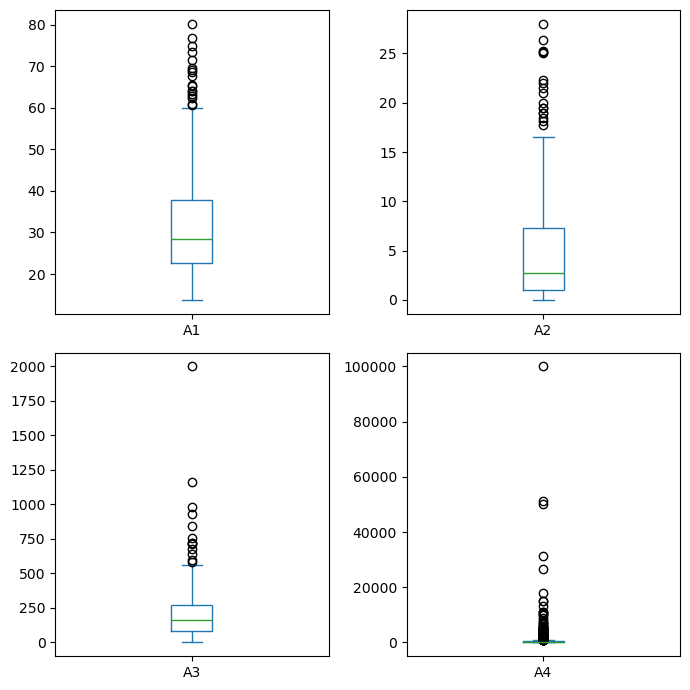

In [348]:
numerical_cols = ['A1', 'A2', 'A3', 'A4']
df[numerical_cols].plot(kind='box', subplots=True, layout=(2,2), figsize=(7,7))
plt.tight_layout()
plt.show();

* Winsorization
* cap the outliers at the whisker limits so we don't lose rows.

In [351]:
for col in ['A1', 'A2', 'A3', 'A4']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower_limit, upper_limit)

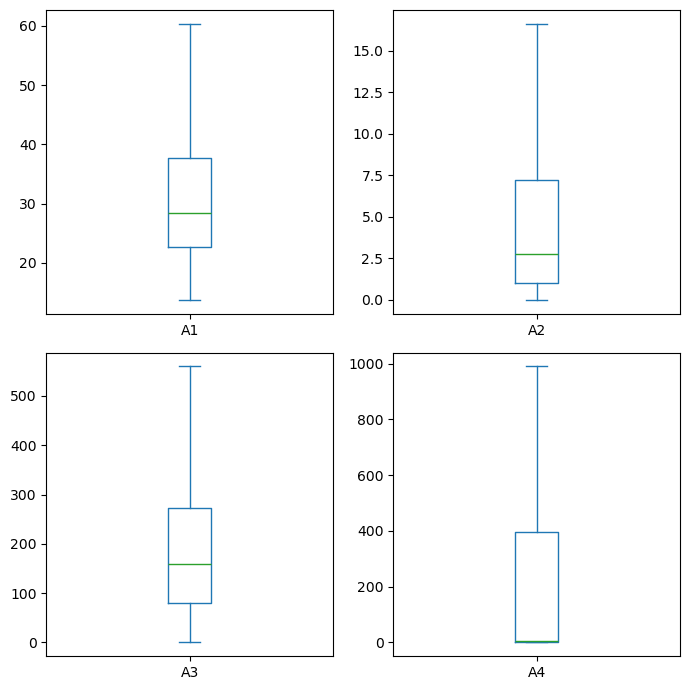

In [352]:
numerical_cols = ['A1', 'A2', 'A3', 'A4']
df[numerical_cols].plot(kind='box', subplots=True, layout=(2,2), figsize=(7,7))
plt.tight_layout()
plt.show();

* Log Transformation for numerical cols

In [356]:
for col in ['A1', 'A2', 'A3', 'A4']:
    df[col] = np.log1p(df[col])

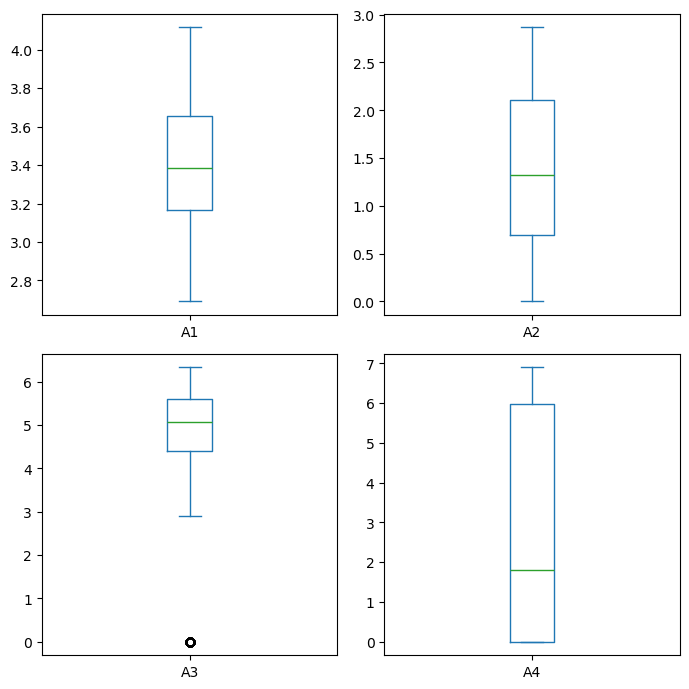

In [358]:
numerical_cols = ['A1', 'A2', 'A3', 'A4']
df[numerical_cols].plot(kind='box', subplots=True, layout=(2,2), figsize=(7,7))
plt.tight_layout()
plt.show();

### 4. Encode variables

* Traget variable `Rsique` using LabelEncoder()

In [362]:
from sklearn.preprocessing import LabelEncoder
df['Risque'] = LabelEncoder().fit_transform(df['Risque'])

* A5, A6 & A7 using get_dummies()

In [365]:
df = pd.get_dummies(df, columns=['A5', 'A6', 'A7'])

In [367]:
df.head(3)

,A1,A2,A3,A4,Risque,A5_g,A5_gg,A5_p,A6_aa,A6_c,...,A6_x,A7_bb,A7_dd,A7_ff,A7_h,A7_j,A7_n,A7_o,A7_v,A7_z
0,3.460409,0.000000,5.313206,0.000000,0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,4.088829,1.697449,3.784190,6.329721,0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,3.238678,0.405465,5.638355,6.715383,0,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


### 5. ML step and training models

#### Split the data into train test :

In [371]:
from sklearn.model_selection import train_test_split

X = df.drop('Risque', axis=1)
y = df['Risque']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [373]:
from sklearn.preprocessing import RobustScaler

# 1. Initialize the scaler
scaler = RobustScaler()

# 2. Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform the test data
X_test_scaled = scaler.transform(X_test)

#### Import ML libraries

In [388]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix

In [378]:
models = {
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(C= 0.1, penalty= 'l2', solver= 'liblinear'),
    "Random Forest": RandomForestClassifier(criterion= 'log_loss', max_depth= 10, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 100),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": XGBClassifier(),
    "SVM": SVC(kernel= 'rbf', gamma= 0.1, C= 1),
    "KNN": KNeighborsClassifier(weights= 'uniform', n_neighbors= 9, metric= 'manhattan')
}

**-> Accuracy**

In [381]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    results[name] = accuracy_score(y_test, predictions)

for name, score in results.items():
    print(f"{name}: {score:.4f}")

Gradient Boosting: 0.7536
Logistic Regression: 0.6884
Random Forest: 0.7319
Decision Tree: 0.6522
XGBoost: 0.7029
SVM: 0.7246
KNN: 0.7101


**-> F1 score**

In [384]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    predictions = model.predict(X_test_scaled)
    results[name] = f1_score(y_test, predictions)

for name, score in results.items():
    print(f"{name}: {score:.4f}")

Gradient Boosting: 0.7763
Logistic Regression: 0.7329
Random Forest: 0.7547
Decision Tree: 0.6753
XGBoost: 0.7421
SVM: 0.7625
KNN: 0.7500


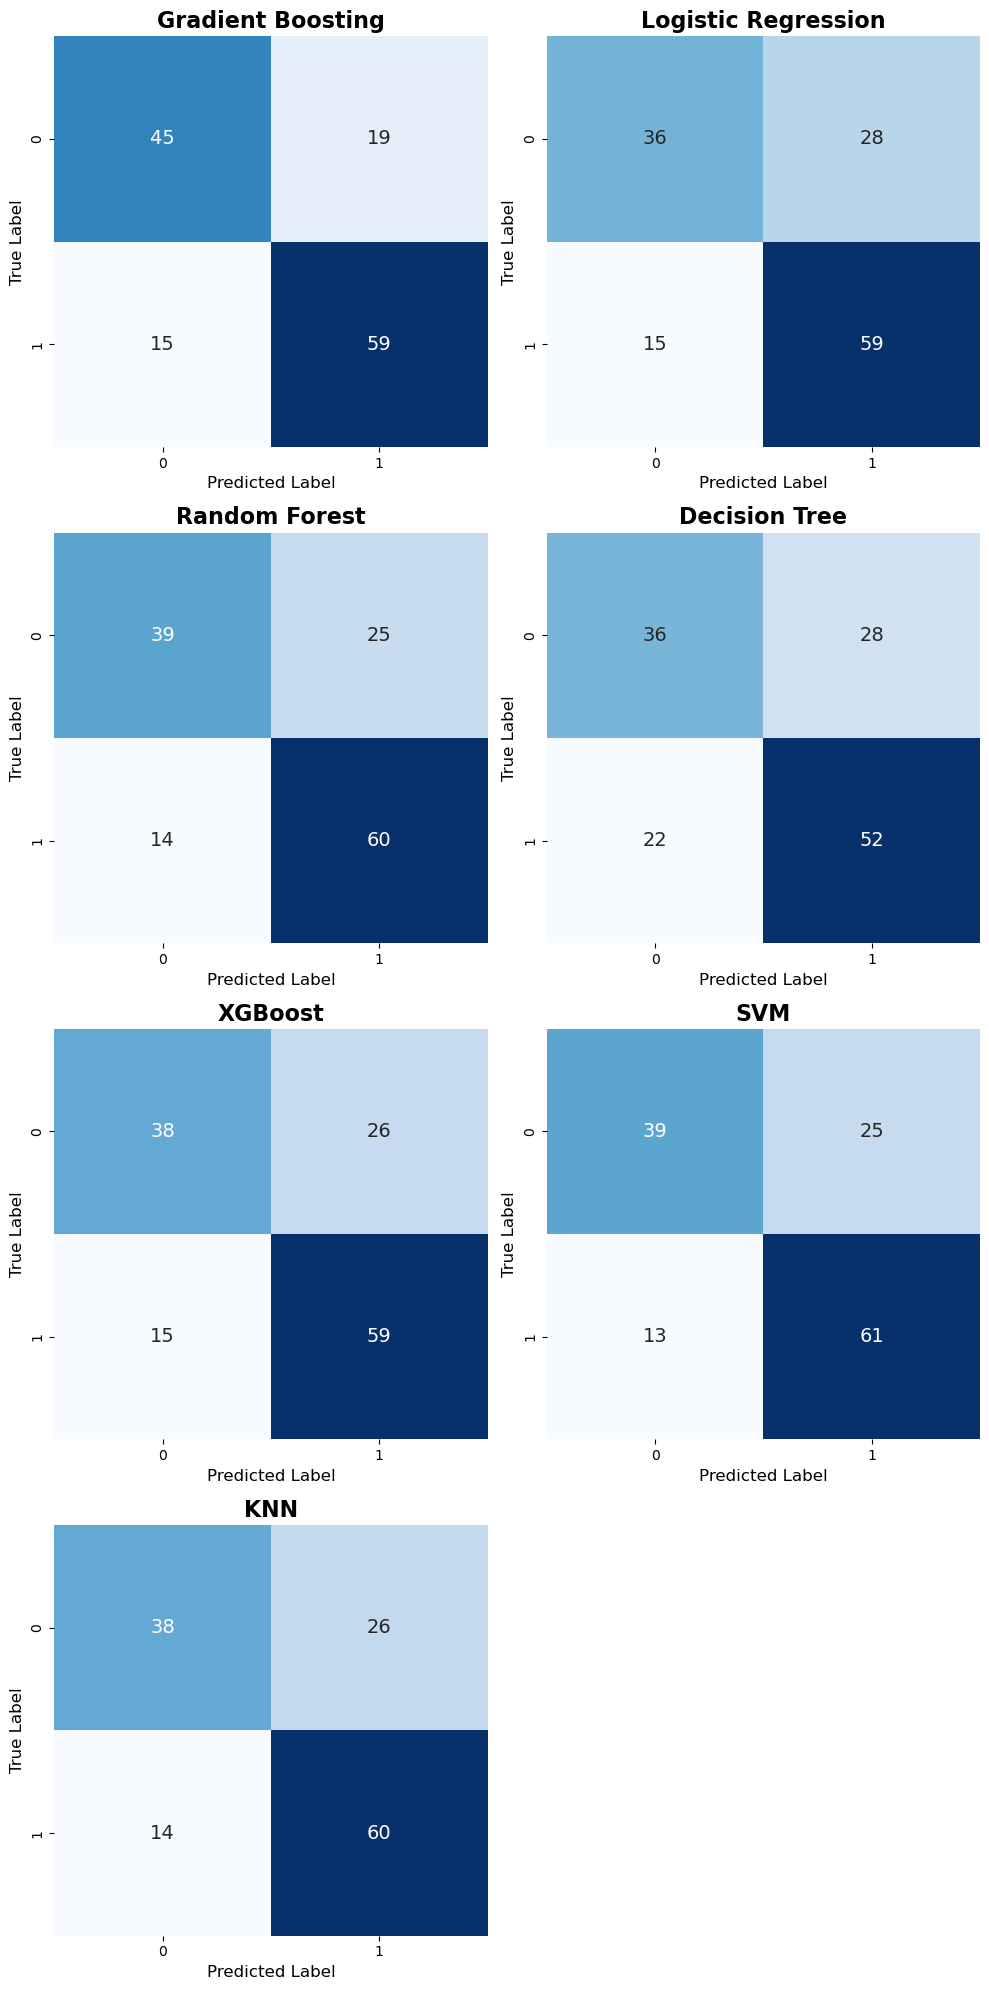

In [390]:
n_models = len(models)
cols = 2  
rows = math.ceil(n_models / cols)

fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 5))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i], annot_kws={"size": 14})
    
    # Formatting
    axes[i].set_title(name, fontsize=16, fontweight='bold')
    axes[i].set_ylabel('True Label', fontsize=12)
    axes[i].set_xlabel('Predicted Label', fontsize=12)

# Hide any empty subplots if the grid is larger than the number of models
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Looking for the best hyperparameters for each model

In [393]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [395]:
param_grid_gb = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_gb = RandomizedSearchCV(GradientBoostingClassifier(), param_grid_gb, cv=5, scoring='accuracy')
grid_gb.fit(X_train, y_train)
print(f"Best GB Params: {grid_gb.best_params_}")
print(f"Best GB Score: {grid_gb.best_score_:.4f}")

Best GB Params: {'subsample': 0.8, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.1}
Best GB Score: 0.7295


In [397]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_lr = RandomizedSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train_scaled, y_train)
print(f"Best LR Params: {grid_lr.best_params_}")
print(f"Best LR Score: {grid_lr.best_score_:.4f}")

Best LR Params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.1}
Best LR Score: 0.7349


In [399]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

grid_rf = RandomizedSearchCV(RandomForestClassifier(), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train_scaled, y_train)
print(f"Best RF Params: {grid_rf.best_params_}")
print(f"Best RF Score: {grid_rf.best_score_:.4f}")

Best RF Params: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 10, 'criterion': 'gini'}
Best RF Score: 0.7404


In [131]:
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')
grid_dt.fit(X_train_scaled, y_train)
print(f"Best Decision Tree Params: {grid_dt.best_params_}")
print(f"Best Decision Tree Score: {grid_dt.best_score_:.4f}")

Best Decision Tree Params: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}
Best Decision Tree Score: 0.6715


In [133]:
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = RandomizedSearchCV(
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), 
    param_grid_xgb, 
    cv=5, 
    scoring='accuracy', 
    n_jobs=-1
)

grid_xgb.fit(X_train_scaled, y_train)

print(f"Best XGB Params: {grid_xgb.best_params_}")
print(f"Best XGB Score: {grid_xgb.best_score_:.4f}")

Best XGB Params: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best XGB Score: 0.7223


In [135]:
param_grid_svc = {
    'C': [0.1, 1, 10, 100, 200],
    'gamma': ['scale', 'auto', 0.01, 0.1, 0.5],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_svc = RandomizedSearchCV(SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_svc.fit(X_train_scaled, y_train)
print(f"Best SVM Params: {grid_svc.best_params_}")
print(f"Best SVM Score: {grid_svc.best_score_:.4f}")

Best SVM Params: {'kernel': 'sigmoid', 'gamma': 'auto', 'C': 1}
Best SVM Score: 0.7295


In [536]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5, scoring='accuracy')
grid_knn.fit(X_train_scaled, y_train)
print(f"Best KNN Params: {grid_knn.best_params_}")
print(f"Best KNN Score: {grid_knn.best_score_:.4f}")

Best KNN Params: {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'euclidean'}
Best KNN Score: 0.7150


#### The Best Model found is `Gradient Boosting`

In [278]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train_scaled, y_train)

y_pred = gb_model.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7536

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.70      0.73        64
           1       0.76      0.80      0.78        74

    accuracy                           0.75       138
   macro avg       0.75      0.75      0.75       138
weighted avg       0.75      0.75      0.75       138



### Save the best model, Gradient Boosting

In [542]:
import pickle

##### Save the model and Scaler

In [544]:
save_data = {
    "model": gb_model,
    "scaler": scaler
}

In [545]:
with open('gb_model.pkl', 'wb') as file:
    pickle.dump(save_data, file)

In [546]:
result = gb_model.predict(X_test_scaled)
result

array([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0])